In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
sns.set()
sns.set(font_scale=1.4)

In [2]:

def readAtomicTimes(file_path):
    names=['name', 'blocks','threads','iterations','size','validated','time']
    df = pd.read_csv(file_path, names=names)
    df['name'] = (df['name'].str
                             .replace('add_as_accumuluated_requests', 'aggregated')
                            .replace('add_as_requests', 'requests')
                            .replace('add_trival', 'trivial'))
    df['total_threads'] = df['threads'] * df['blocks']
    # time 100 to get seconds and not milliseconds
    df['throughput'] = 100 * df['iterations'] * df['total_threads'] / df['time']
    return df

def plotAtomics(df, x, title, ax=None, min=10**4, max=10**10):
    palette=['#D98880', '#58D68D', '#A569BD', '#4e98f5', '#A93226', '#28B463', '#6C3483', '#145cb5']
    hue=df[['name', 'size']].apply(lambda x: (x['name'] + '-' + str(x['size'])), axis=1)
    plot = sns.lineplot(data=df, x=x, y='throughput', palette=palette, markers=True, dashes=False, ax=ax, style=hue,
                        hue=hue)
    plot.set_xscale('log', base=2)
    plot.set(title=title)
    plot.set(yscale='log')
    plot.set(xlabel='Number of threads')
    plot.set(ylabel='Throughput (ops/sec)')
    plot.set_ylim(min, max)

    plot.get_legend().remove()
    
def plotQueues(df, x, title, ax=None, min=10**4, max=10**10, ylabel='Throughput (enq+deq/sec)'):
    plot = sns.lineplot(data=df, x=x, y='throughput',hue='name', style='name', markers=True, dashes=False, ax=ax)
    plot.set_xscale('log', base=2)
    plot.set(xlabel='Number of threads')
    plot.set(ylabel=ylabel)
    plot.set(yscale='log')
    plot.set(title=title)
    plot.set_ylim(min, max)
    # sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))
    plot.get_legend().remove()



def readQueuTimes(file_path):
    names=['platform', 'name','threads','blocks','iterations', 'ringbuffersize','time']
    df = pd.read_csv(file_path, names=names)
    df['total_threads'] = df['threads'] * df['blocks']
    # time 100 to get seconds and not milliseconds
    # times 2 because we do push and pop
    df['throughput'] = 2 * 100 * df['iterations'] * df['total_threads'] / df['time']
    return df

def readHashMapTimes(file_path):
    names=['name', 'load', 'block_size', 'cas_retries', 'collisions', 'keycount', 'true_load', 'insert_ms', 'find_ms', 'insert_qps', 'find_qps', 'insert_GBps', 'find_GBps']
    df = pd.read_csv(file_path, names=names, delimiter=' ')
    return df

def readHashMapCopyTimes(file_path):
    names=['elements', 'insert_time', 'find_time']
    df = pd.read_csv(file_path, names=names, delimiter=' ')
    # time 100 to get seconds and not milliseconds
    df['insert_throughput'] = 100 * df['elements'] / df['insert_time']
    df['find_throughput'] = 100 * df['elements'] / df['find_time']
    
    return df

# Atomics

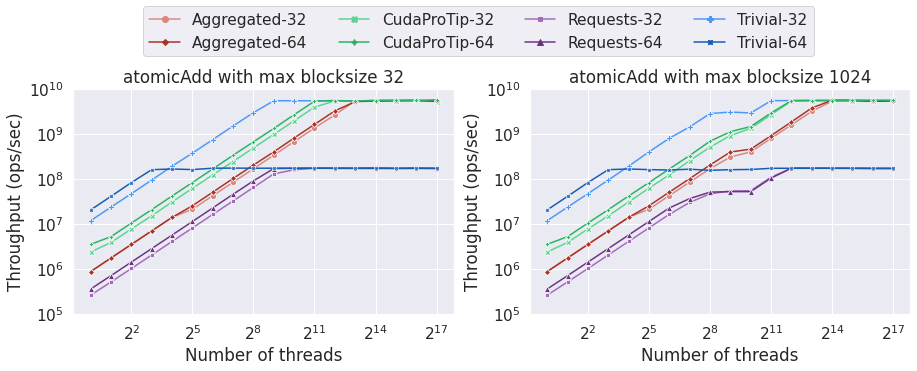

In [3]:

fig, ax =plt.subplots(1,2)
fig.figure.set_size_inches(15, 5)

blocksize = 32
atomicadd1 = readAtomicTimes("../results/atomicadd_singleblock.txt")
atomicadd1 = atomicadd1[(atomicadd1["threads"]<blocksize)]
atomicadd2 = readAtomicTimes("../results/atomicadd.txt")
atomicadd2 = atomicadd2[(atomicadd2["threads"]==blocksize)]
atomicadd = atomicadd1.append(atomicadd2, ignore_index=True)
plotAtomics(atomicadd, x='total_threads', title='atomicAdd with max blocksize 32', ax=ax[0], min=10**5)

blocksize = 1024
atomicadd1 = readAtomicTimes("../results/atomicadd_singleblock.txt")
atomicadd1 = atomicadd1[(atomicadd1["threads"]<blocksize)]
atomicadd2 = readAtomicTimes("../results/atomicadd.txt")
atomicadd2 = atomicadd2[(atomicadd2["threads"]==blocksize)]
atomicadd2 = atomicadd2[(atomicadd2["total_threads"]<=2**17)]
atomicadd = atomicadd1.append(atomicadd2, ignore_index=True)
plotAtomics(atomicadd, x='total_threads', title='atomicAdd with max blocksize 1024', ax=ax[1], min=10**5)

handles, labels = ax[0].get_legend_handles_labels()
# sort hadles and labels by labels
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1))
plt.subplots_adjust(top=0.75)
plt.savefig("plots/atomicadd_blocksize1024vs32.svg",bbox_inches='tight')

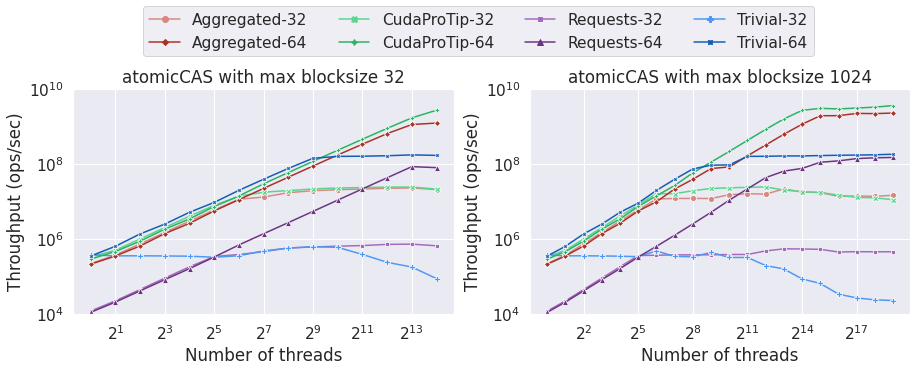

In [4]:
fig, ax =plt.subplots(1,2)
fig.figure.set_size_inches(15, 5)

blocksize = 32
atomiccas_oneblock = readAtomicTimes("../results/atomiccas_singleblock.txt")
atomiccas_oneblock = atomiccas_oneblock[(atomiccas_oneblock["threads"]<blocksize)]
atomiccas = readAtomicTimes("../results/atomiccas.txt")
atomiccas = atomiccas[(atomiccas["threads"]==blocksize)]
atomiccas = atomiccas_oneblock.append(atomiccas, ignore_index=True)
plotAtomics(atomiccas, x='total_threads', title='atomicCAS with max blocksize 32', ax=ax[0])

blocksize = 1024
atomiccas_oneblock = readAtomicTimes("../results/atomiccas_singleblock.txt")
atomiccas_oneblock = atomiccas_oneblock[(atomiccas_oneblock["threads"]<blocksize)]
atomiccas = readAtomicTimes("../results/atomiccas.txt")
atomiccas = atomiccas[(atomiccas["threads"]==blocksize)]
atomiccas = atomiccas_oneblock.append(atomiccas, ignore_index=True)
plotAtomics(atomiccas, x='total_threads', title='atomicCAS with max blocksize 1024', ax=ax[1])

handles, labels = ax[0].get_legend_handles_labels()
# sort hadles and labels by labels
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1))
plt.subplots_adjust(top=0.75)
plt.savefig("plots/atomiccas_blocksize1024vs32.svg",bbox_inches='tight')

# Queues

In [5]:
queue_times = readQueuTimes("../results/queues_final.txt")
queue_times['name'] = (queue_times['name'].str
                             .replace('BrokerQueueFast', 'ModifiedBrokerQueue'))
cpu_queue_times = readQueuTimes("../results/cpu_queues_final.txt")
cpu_queue_times['name'] = (cpu_queue_times['name'].str
                             .replace('BrokerQueue', 'CPU-BrokerQueue')
                             .replace('CASRingBuffer', 'CPU-CASRingBuffer'))
queue_times = queue_times.append(cpu_queue_times, ignore_index=True)

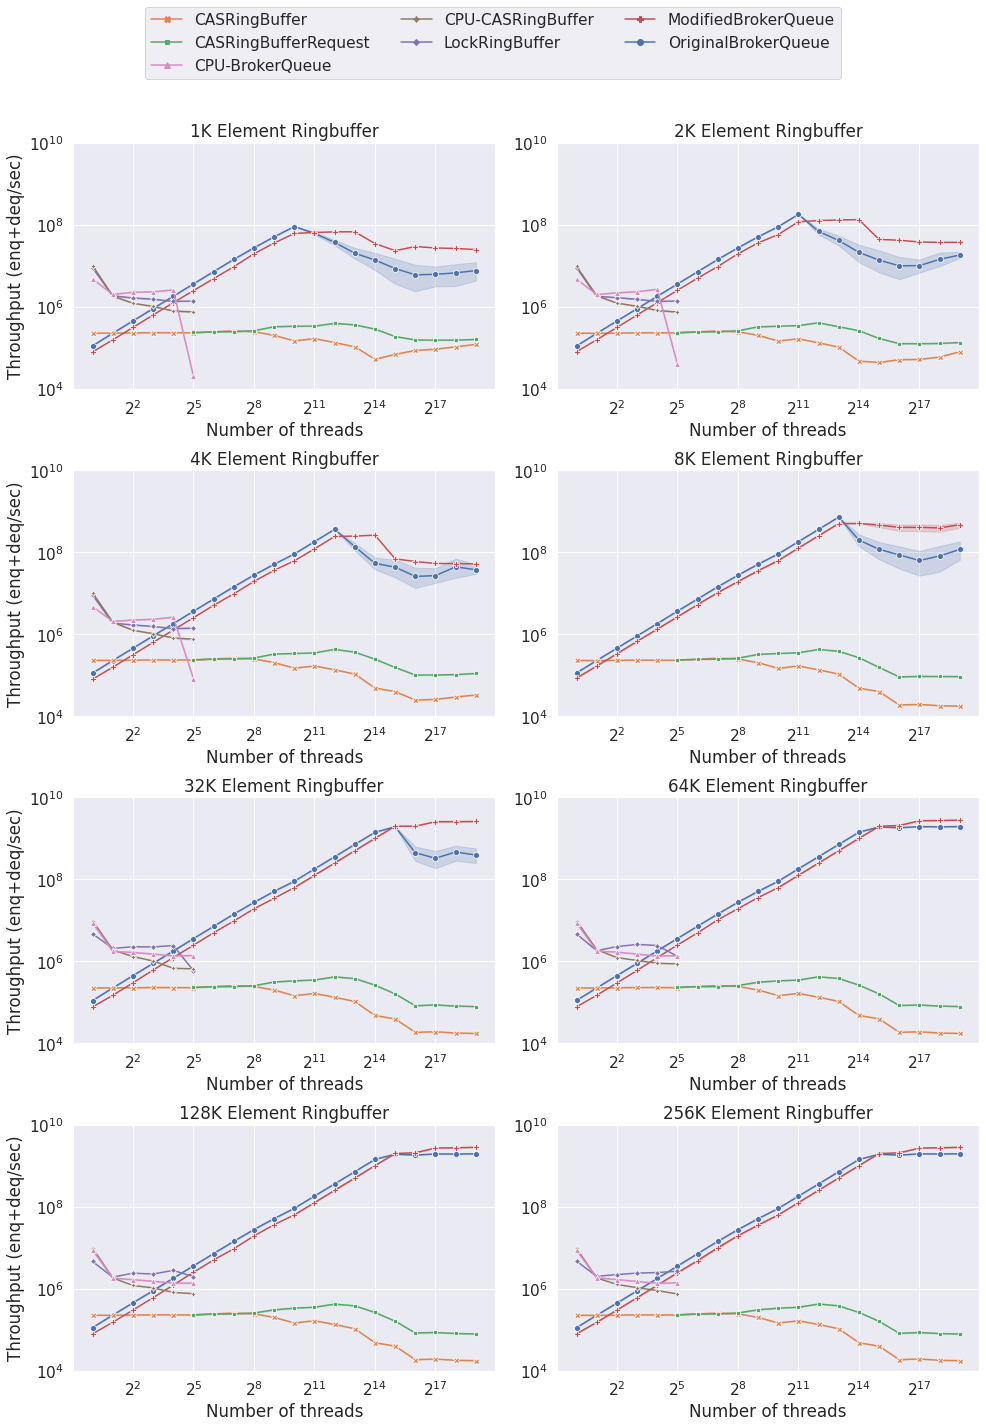

In [6]:
fig, ax =plt.subplots(4,2)
fig.figure.set_size_inches(14, 20)

queue_times1 = queue_times[(queue_times["ringbuffersize"]== 1 * 1024)]
plotQueues(queue_times1, 'total_threads', ax=ax[0,0], title='1K Element Ringbuffer')

queue_times2 = queue_times[(queue_times["ringbuffersize"]== 2 * 1024)]
plotQueues(queue_times2, 'total_threads', ax=ax[0,1], title='2K Element Ringbuffer', ylabel=None)

queue_times4 = queue_times[(queue_times["ringbuffersize"]== 4 * 1024)]
plotQueues(queue_times4, 'total_threads', ax=ax[1,0], title='4K Element Ringbuffer')

queue_times8 = queue_times[(queue_times["ringbuffersize"]== 8 * 1024)]
plotQueues(queue_times8, 'total_threads', ax=ax[1,1], title='8K Element Ringbuffer', ylabel=None)


queue_times32 = queue_times[(queue_times["ringbuffersize"]== 32 * 1024)]
plotQueues(queue_times32, 'total_threads', ax=ax[2,0], title='32K Element Ringbuffer')
#64
queue_times64 = queue_times[(queue_times["ringbuffersize"]== 64 * 1024)]
plotQueues(queue_times64, 'total_threads', ax=ax[2,1], title='64K Element Ringbuffer', ylabel=None)

#128K Element Ringbuffer
queue_times128 = queue_times[(queue_times["ringbuffersize"]== 128 * 1024)]
plotQueues(queue_times128, 'total_threads', ax=ax[3,0], title='128K Element Ringbuffer')

#256K Element Ringbuffer
queue_times256 = queue_times[(queue_times["ringbuffersize"]== 256 * 1024)]
plotQueues(queue_times256, 'total_threads', ax=ax[3,1], title='256K Element Ringbuffer', ylabel=None)

handles, labels = ax[0,0].get_legend_handles_labels()
# sort hadles and labels by labels
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1))
fig.tight_layout()
plt.subplots_adjust(top=0.9)
plt.savefig("plots/queues.svg",bbox_inches='tight')


# HashMaps

In [7]:
def plotHashInsert(df, x, y, logxscale=True, min=5*10**8, max=2*10**9, ax=None, title=None,ylabel='Throughput (ops/sec)',xlabel='Group Size'):
    plot = sns.lineplot(data=df, x=x, y=y, marker="o", ax=ax,
                        hue=df[['useBuckets', 'probing']].apply(lambda x: (x['probing'] + '-Buckets:' + str(x['useBuckets'])), axis=1))
    
    if logxscale:
        plot.set_xscale('log', base=2)
    
    plot.set(yscale='log')
    plot.set_ylim(min, max)
    # sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))
    plot.get_legend().remove()
    plot.set(title=title)
    plot.set(xlabel=xlabel)
    plot.set(ylabel=ylabel)
    return plot

def plotHashInsertTheir(df, x, y, logxscale=True, ax=None, min=None, max=None, title=None,ylabel='Throughput (ops/sec)',xlabel='Group Size',hue='name', ybase=10):
    plot = sns.lineplot(data=df, x=x, y=y, marker="o", ax=ax,
                        hue=hue, palette="rocket")
    if logxscale:
        plot.set_xscale('log', base=2)
    
    # plot.set(yscale='log', base=ybase)
    plot.set_yscale('log', base=ybase)
    plot.set_ylim(min, max)
    # sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))
    if plot.get_legend():
        plot.get_legend().remove()
    plot.set(title=title)
    plot.set(xlabel=xlabel)
    plot.set(ylabel=ylabel)
    
def name_to_properties(name):
    name, prob, usebucket, groupsize, layout, vecread  = name.split('|')
    usebucket = usebucket.split(':')[1] == '1'
    groupsize = int(groupsize.split(':')[1])
    layout = layout.split(':')[1] 
    vecread = int(vecread.split(':')[1])
    return prob, usebucket, groupsize, layout, vecread

def prepareData(hash_times):
    my_times = hash_times[~hash_times['name'].isin(['DycuckooHashTableWrapper', 'WarpCore'])]
    my_times['probing'], my_times['useBuckets'], my_times['groupsize'], my_times['layout'], my_times['vecread'] = zip(
        *my_times['name'].map(name_to_properties))
    return my_times


/tmp/ipykernel_19261/3721285210.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_times['probing'], my_times['useBuckets'], my_times['groupsize'], my_times['layout'], my_times['vecread'] = zip(


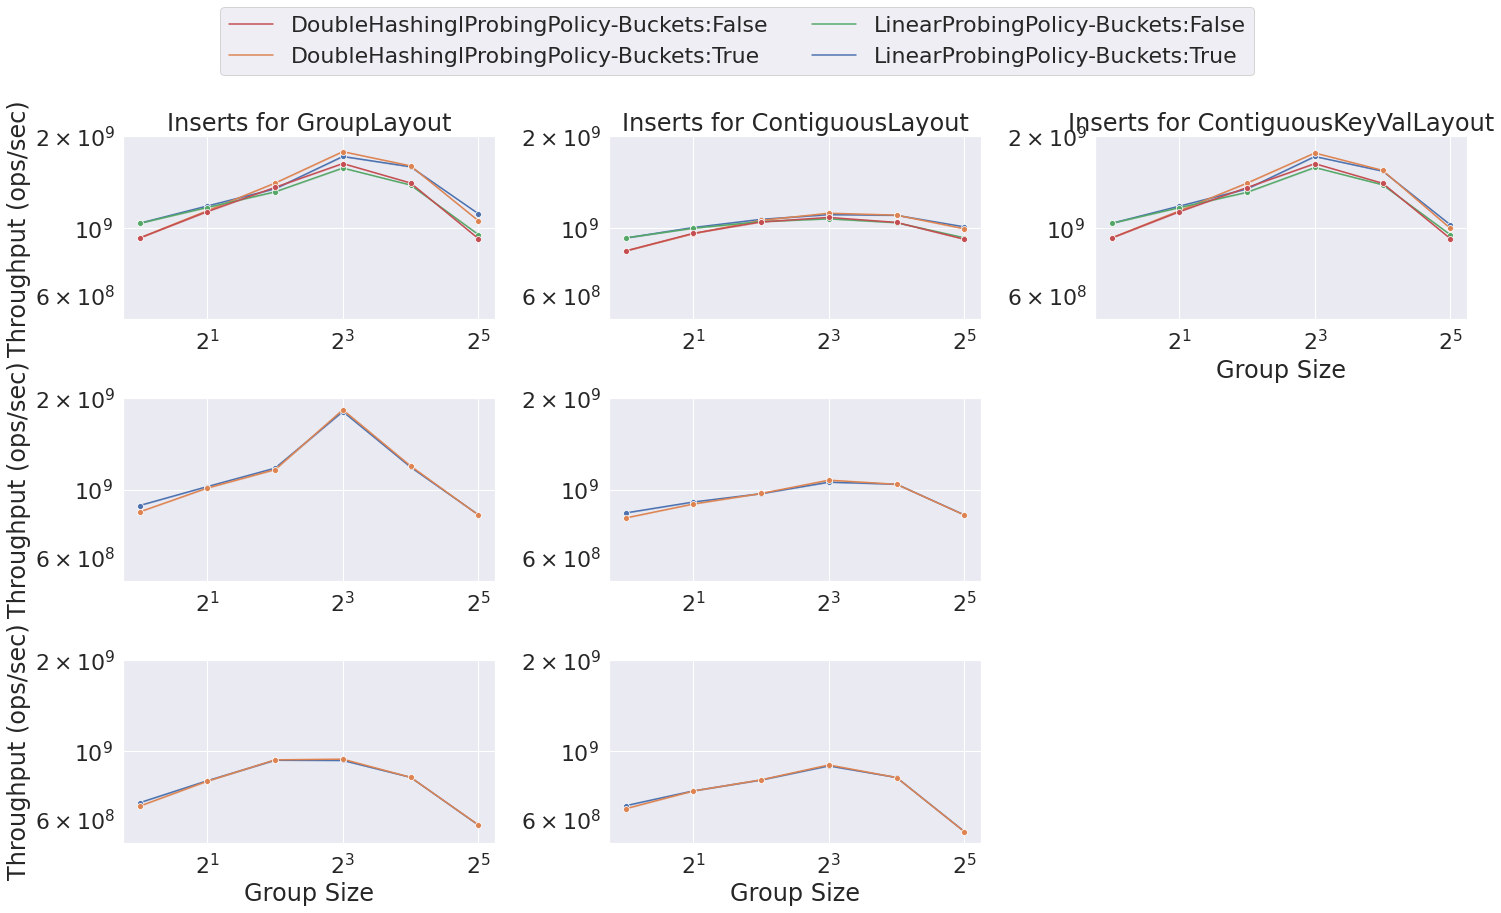

In [8]:

sns.set(font_scale=2)
hash_times = readHashMapTimes('../results/hash_table_all_final.txt')
my_times= prepareData(hash_times)

fig, ax =plt.subplots(3,3)
fig.figure.set_size_inches(21, 13)

density = 0.8

dens80 = my_times[(my_times['load'] == density) & (my_times['vecread'] == 1) & (my_times['layout'] == 'GroupLayout') ]
plotHashInsert(dens80, 'groupsize','insert_qps', ax=ax[0,0], title='Inserts for GroupLayout',xlabel=None)

dens80 = my_times[(my_times['load'] == density) & (my_times['vecread'] == 1) & (my_times['layout'] == 'ContiguousLayout') ]
plotHashInsert(dens80, 'groupsize','insert_qps', ax=ax[0,1], ylabel=None, title='Inserts for ContiguousLayout',xlabel=None)

dens80 = my_times[(my_times['load'] == density) & (my_times['vecread'] == 1) & (my_times['layout'] == 'ContiguousKeyValLayout') ]
plotHashInsert(dens80, 'groupsize','insert_qps', ax=ax[0,2], ylabel=None, title='Inserts for ContiguousKeyValLayout')

dens80 = my_times[(my_times['load'] == density) & (my_times['vecread'] == 2) & (my_times['layout'] == 'GroupLayout') ]
plotHashInsert(dens80, 'groupsize','insert_qps', ax=ax[1,0],xlabel=None)
ax[1,2].set_axis_off()

dens80 = my_times[(my_times['load'] == density) & (my_times['vecread'] == 2) & (my_times['layout'] == 'ContiguousLayout') ]
plotHashInsert(dens80, 'groupsize','insert_qps', ax=ax[1,1], ylabel=None,xlabel=None)

dens80 = my_times[(my_times['load'] == density) & (my_times['vecread'] == 4) & (my_times['layout'] == 'GroupLayout') ]
plotHashInsert(dens80, 'groupsize','insert_qps', ax=ax[2,0])

dens80 = my_times[(my_times['load'] == density) & (my_times['vecread'] == 4) & (my_times['layout'] == 'ContiguousLayout') ]
plotHashInsert(dens80, 'groupsize','insert_qps', ax=ax[2,1], ylabel=None)
ax[2,2].set_axis_off()

# Does not exists
# dens80 = my_times[(my_times['load'] == density) & (my_times['vecread'] == 2) & (my_times['layout'] == 'ContiguousKeyValLayout') ]
# plotHashInsert(dens80, 'groupsize','insert_qps', ax=ax[1,2])


handles, labels = ax[0,0].get_legend_handles_labels()
# sort hadles and labels by labels
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1))
fig.tight_layout()
plt.subplots_adjust(top=0.85)
plt.savefig("plots/hash_table_insert.svg",bbox_inches='tight')


/tmp/ipykernel_19261/3721285210.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_times['probing'], my_times['useBuckets'], my_times['groupsize'], my_times['layout'], my_times['vecread'] = zip(


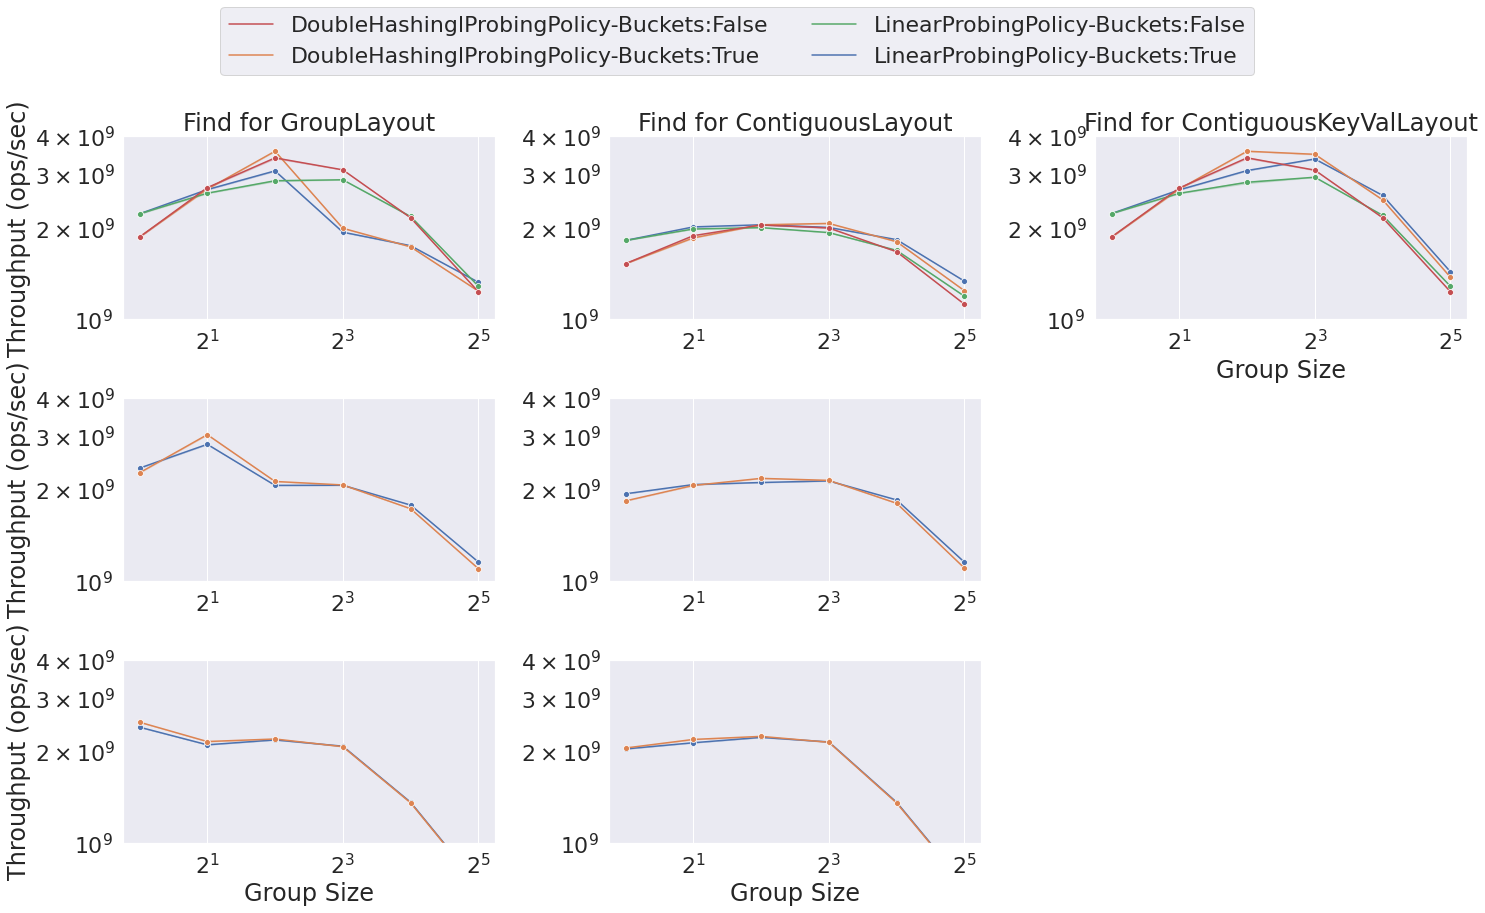

In [9]:
hash_times = readHashMapTimes('../results/hash_table_all_final.txt')
my_times= prepareData(hash_times)

fig, ax =plt.subplots(3,3)
fig.figure.set_size_inches(21, 13)
min = 10**9
max = 4 * 10**9

density = 0.8

dens80 = my_times[(my_times['load'] == density) & (my_times['vecread'] == 1) & (my_times['layout'] == 'GroupLayout') ]
plotHashInsert(dens80, 'groupsize','find_qps', ax=ax[0,0], title='Find for GroupLayout',xlabel=None, min=min, max=max)

dens80 = my_times[(my_times['load'] == density) & (my_times['vecread'] == 1) & (my_times['layout'] == 'ContiguousLayout') ]
plotHashInsert(dens80, 'groupsize','find_qps', ax=ax[0,1], ylabel=None, title='Find for ContiguousLayout',xlabel=None, min=min, max=max)

dens80 = my_times[(my_times['load'] == density) & (my_times['vecread'] == 1) & (my_times['layout'] == 'ContiguousKeyValLayout') ]
plotHashInsert(dens80, 'groupsize','find_qps', ax=ax[0,2], ylabel=None, title='Find for ContiguousKeyValLayout', min=min, max=max)

dens80 = my_times[(my_times['load'] == density) & (my_times['vecread'] == 2) & (my_times['layout'] == 'GroupLayout') ]
plotHashInsert(dens80, 'groupsize','find_qps', ax=ax[1,0],xlabel=None, min=min, max=max)
ax[1,2].set_axis_off()

dens80 = my_times[(my_times['load'] == density) & (my_times['vecread'] == 2) & (my_times['layout'] == 'ContiguousLayout') ]
plotHashInsert(dens80, 'groupsize','find_qps', ax=ax[1,1], ylabel=None,xlabel=None, min=min, max=max)

dens80 = my_times[(my_times['load'] == density) & (my_times['vecread'] == 4) & (my_times['layout'] == 'GroupLayout') ]
plotHashInsert(dens80, 'groupsize','find_qps', ax=ax[2,0], min=min, max=max)

dens80 = my_times[(my_times['load'] == density) & (my_times['vecread'] == 4) & (my_times['layout'] == 'ContiguousLayout') ]
plotHashInsert(dens80, 'groupsize','find_qps', ax=ax[2,1], ylabel=None, min=min, max=max)
ax[2,2].set_axis_off()

# Does not exists
# dens80 = my_times[(my_times['load'] == density) & (my_times['vecread'] == 2) & (my_times['layout'] == 'ContiguousKeyValLayout') ]
# plotHashInsert(dens80, 'groupsize','insert_qps', ax=ax[1,2])

handles, labels = ax[0,0].get_legend_handles_labels()
# sort hadles and labels by labels
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1))
fig.tight_layout()
plt.subplots_adjust(top=0.85)
plt.savefig("plots/hash_table_find.svg",bbox_inches='tight')

In [10]:
sns.set(font_scale=1.4)

/tmp/ipykernel_19261/3721285210.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_times['probing'], my_times['useBuckets'], my_times['groupsize'], my_times['layout'], my_times['vecread'] = zip(
/tmp/ipykernel_19261/1292791976.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_times['cas_retries'] = my_times['cas_retries'] / 2**26
/tmp/ipykernel_19261/1292791976.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

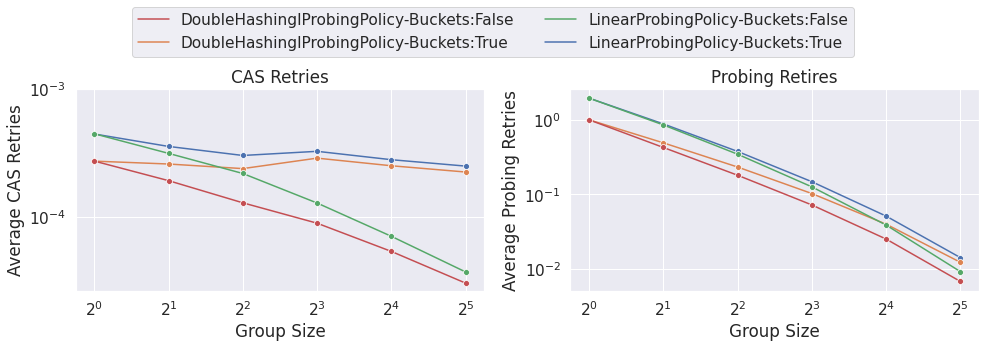

In [11]:
hash_times = readHashMapTimes('../results/hash_maps_all_collisions.txt')
my_times= prepareData(hash_times)

fig, ax =plt.subplots(1,2)
fig.figure.set_size_inches(14, 5)

my_times['cas_retries'] = my_times['cas_retries'] / 2**26
my_times['collisions'] = my_times['collisions'] / 2**26

density = 0.8
dens80 = my_times[(my_times['load'] == density) & (my_times['vecread'] == 1) & (my_times['layout'] == 'GroupLayout')]
plotHashInsert(dens80, 'groupsize','cas_retries', ax=ax[0], min=None, max=10**-3, ylabel='Average CAS Retries', title='CAS Retries')

dens80 = my_times[(my_times['load'] == density) & (my_times['vecread'] == 1) & (my_times['layout'] == 'GroupLayout') ]
plotHashInsert(dens80, 'groupsize','collisions', ax=ax[1], min=None, max=None, ylabel='Average Probing Retries', title='Probing Retires')

handles, labels = ax[0].get_legend_handles_labels()
# sort hadles and labels by labels
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1))
fig.tight_layout()
plt.subplots_adjust(top=0.75)
plt.savefig("plots/hash_table_collisions.svg",bbox_inches='tight')



/tmp/ipykernel_19261/3721285210.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_times['probing'], my_times['useBuckets'], my_times['groupsize'], my_times['layout'], my_times['vecread'] = zip(
/tmp/ipykernel_19261/3542713042.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_times['name'] = my_times[['useBuckets', 'probing']].apply(lambda x: (x['probing'] + '-Buckets:' + str(x['useBuckets'])), axis=1)
/usr/lib/python3/dist-packages/pandas/core/frame.py:7134: FutureWarning: Sorting because non-conca

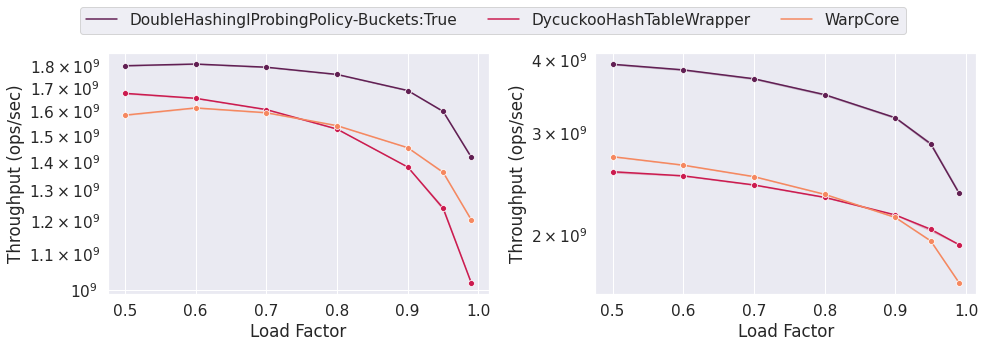

In [12]:
hash_times = readHashMapTimes('../results/hash_table_all_final.txt')
my_times= prepareData(hash_times)
my_times['name'] = my_times[['useBuckets', 'probing']].apply(lambda x: (x['probing'] + '-Buckets:' + str(x['useBuckets'])), axis=1)
their_times = hash_times[hash_times['name'].isin(['DycuckooHashTableWrapper', 'WarpCore'])]

fig, ax =plt.subplots(1,2)
fig.figure.set_size_inches(14, 5)

my_stuff = my_times[(my_times['groupsize'] == 8 ) & (my_times['vecread'] == 1) & (my_times['useBuckets'] == True) & (my_times['probing'] == 'DoubleHashinglProbingPolicy')  & (my_times['layout'] == 'ContiguousKeyValLayout') ]
all = my_stuff.append(their_times)

plotHashInsertTheir(all, 'load', 'insert_qps', False, ax=ax[0], min=None, max=None, xlabel='Load Factor')
# plotHashInsert(my_stuff.append(their_times), 'load', 'insert_qps', False, ax=ax[0])

plotHashInsertTheir(all, 'load', 'find_qps', False, ax=ax[1], min=None, max=None, xlabel='Load Factor')

handles, labels = ax[0].get_legend_handles_labels()
# sort hadles and labels by labels
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1))
fig.tight_layout()
plt.subplots_adjust(top=0.85)
plt.savefig("plots/hash_table_scaling.svg",bbox_inches='tight')

/tmp/ipykernel_19261/3721285210.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_times['probing'], my_times['useBuckets'], my_times['groupsize'], my_times['layout'], my_times['vecread'] = zip(
/tmp/ipykernel_19261/3008600714.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_times['name'] = my_times[['useBuckets', 'probing']].apply(lambda x: (x['probing'] + '-Buckets:' + str(x['useBuckets'])), axis=1)
/usr/lib/python3/dist-packages/pandas/core/frame.py:7134: FutureWarning: Sorting because non-conca

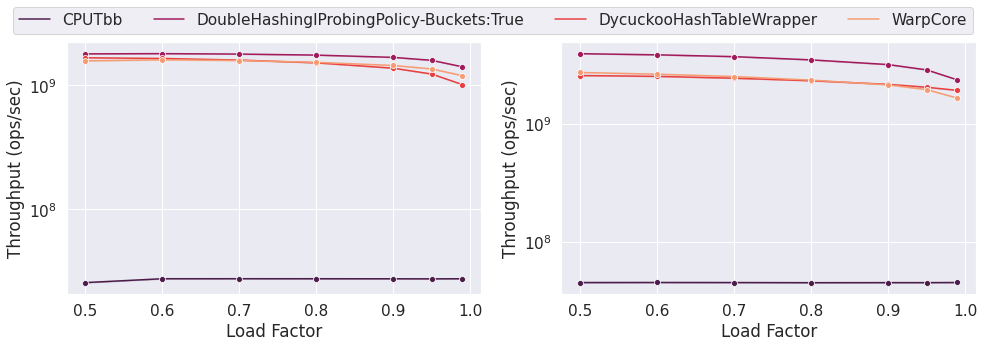

In [13]:
hash_times = readHashMapTimes('../results/hash_table_all_final.txt')
my_times= prepareData(hash_times)
my_times['name'] = my_times[['useBuckets', 'probing']].apply(lambda x: (x['probing'] + '-Buckets:' + str(x['useBuckets'])), axis=1)
their_times = hash_times[hash_times['name'].isin(['DycuckooHashTableWrapper', 'WarpCore'])]

cpu_times = readHashMapTimes('../results/hash_table_cpu_final.txt')
my_cpu_times = cpu_times[cpu_times['block_size'] == 1]

my_stuff = my_times[(my_times['groupsize'] == 8 ) & (my_times['vecread'] == 1) & (my_times['useBuckets'] == True) & (my_times['probing'] == 'DoubleHashinglProbingPolicy')  & (my_times['layout'] == 'ContiguousKeyValLayout') ]
all = my_stuff.append(their_times)
all = my_cpu_times.append(all).reset_index(drop=True)


fig, ax =plt.subplots(1,2)
fig.figure.set_size_inches(14, 5)

plotHashInsertTheir(all, 'load', 'insert_qps', False, ax=ax[0], min=None, max=None, xlabel='Load Factor')

plotHashInsertTheir(all, 'load', 'find_qps', False, ax=ax[1], min=None, max=None, xlabel='Load Factor')

handles, labels = ax[0].get_legend_handles_labels()
# sort hadles and labels by labels
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1))
fig.tight_layout()
plt.subplots_adjust(top=0.88)
plt.savefig("plots/queues2.svg",bbox_inches='tight')



/tmp/ipykernel_19261/52902508.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_cpu_times['name'] = 'CPU TBB'


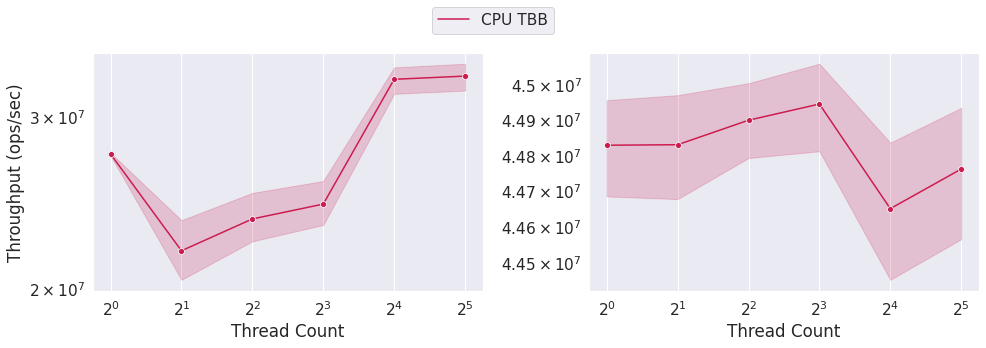

In [14]:
cpu_times = readHashMapTimes('../results/hash_table_cpu_final.txt')
my_cpu_times = cpu_times[cpu_times['load'] == 0.8]

fig, ax =plt.subplots(1,2)
fig.figure.set_size_inches(14, 5)
my_cpu_times['name'] = 'CPU TBB'

plotHashInsertTheir(my_cpu_times, 'block_size', 'insert_qps', True, ax=ax[0], min=None, max=None, xlabel='Thread Count')
plotHashInsertTheir(my_cpu_times, 'block_size', 'find_qps', True, ax=ax[1], min=None, max=None, xlabel='Thread Count', ylabel=None)

handles, labels = ax[0].get_legend_handles_labels()
# sort hadles and labels by labels
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1))
fig.tight_layout()
plt.subplots_adjust(top=0.85)
plt.savefig("plots/hash_table_scaling_threads_cpu.svg",bbox_inches='tight')


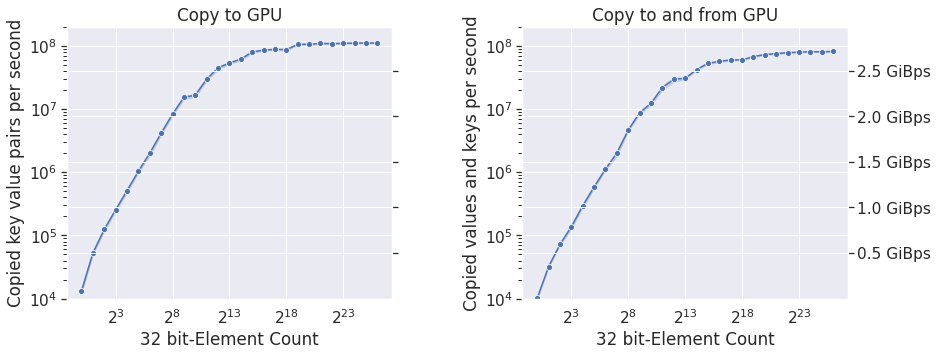

In [15]:
from matplotlib.ticker import FormatStrFormatter

copy_times = readHashMapCopyTimes('../results/hash_table_copy_final.txt')

fig, ax =plt.subplots(1,2)
fig.figure.set_size_inches(14, 5)
fig.subplots_adjust(wspace=0.4)

side = ax[0].twinx()
side.set_ylim(10**4 * 16 / 2**30, 2 * 10**8* 16 / 2**30)
side.yaxis.set_major_formatter(FormatStrFormatter(''))
plotHashInsertTheir(copy_times, 'elements', 'insert_throughput', True, title='Copy to GPU', ax=ax[0], min=None, max=None,ylabel="Copied key value pairs per second", xlabel='32 bit-Element Count', hue=None)

ax[0].set_ylim(10**4,2 * 10**8)

side = ax[1].twinx()
side.set_ylim(10**4 * 16 / 2**30, 2 * 10**8 * 16 / 2**30)
side.yaxis.set_major_formatter(FormatStrFormatter('%.1f GiBps'))

plotHashInsertTheir(copy_times, 'elements', 'find_throughput', True, title='Copy to and from GPU', ax=ax[1], min=None, max=None,ylabel="Copied values and keys per second", xlabel='32 bit-Element Count', hue=None)
ax[1].set_ylim(10**4,2 * 10**8)

plt.savefig("plots/hash_table_copying.svg",bbox_inches='tight')



# Graphs

In [16]:
def readBFStimes(file_path):
    names=['Graph Name', 'storage', 'algo', 'groupsize', 'time', 'copy_time']
    df = pd.read_csv(file_path, names=names, delimiter=' ')
    df['total_time'] = df['time'] + df['copy_time']
    return df
bfs_times = readBFStimes('../results/real_world_bfs6.txt')


def readLigraBFStimes(file_path):
    names=['Graph Name', 'threadcount', 'time']
    df = pd.read_csv(file_path, names=names, delimiter=' ')
    df['time'] = df['time'] * 1000
    df['total_time'] = df['time'] 
    df['algo'] = 'ligra'
    return df

ligra_bfs_times = readLigraBFStimes('../results/ligra_real_world_bfs.txt')
ligra_8_threads = ligra_bfs_times[ligra_bfs_times['threadcount'] == 8]
# add cpu time from bfs_times
cpu_times = bfs_times[bfs_times['algo'] == 'cpu']
cpu_times = cpu_times.drop(columns=['storage', 'groupsize', 'copy_time'])
cpu_times['threadcount'] = 1
ligra_bfs_times = ligra_bfs_times.append(cpu_times)


bfs_times = bfs_times[bfs_times['algo'] != 'cpu']

ligra_8_threads['storage'] = ''
ligra_8_threads['groupsize'] = 1
ligra_8_threads['algo'] = 'Ligra'
ligra_8_threads['total_time'] = ligra_8_threads['time']
ligra_8_threads['copy_time'] = 0

bfs_times = bfs_times.append(ligra_8_threads)


/usr/lib/python3/dist-packages/pandas/core/frame.py:7134: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return concat(


In [17]:
def adjustPalette(palette, repetitions):
    new_palette = []
    i = 0
    for reps, color in repetitions:
        for j in range(reps):
            new_palette.append(palette[color])
        i += 1
    return new_palette

def adjust_name(x):
    layout = x[0]
    name = x[1].replace('_', ' ').replace('bfs', 'BFS')
    if name.startswith('Ligra'):
        return 'Ligra'
    if name.startswith('gunrock'):
        return layout + ' ' + name
    if name.startswith('copy'):
        return 'Copy ' + layout + ' to GPU'
    return layout + ' ' + name + '-Group Size:' + str(x[2])

def plot_bfs(bfs_times, y, ax=None, show_copy=False):
    if not show_copy:
        bfs_times = bfs_times[bfs_times['algo'] != 'copy']
        palette=adjustPalette(sns.color_palette("Paired"), [(1,0),(1,1),(1,4),(1,5),(1,6),(10,2),(10,3),(1,11)])
    else:
        palette=adjustPalette(sns.color_palette("Paired"), [(1,9),(1,8),(1,0),(1,1),(1,4),(1,5),(1,6),(10,2),(10,3),(1,11)])
        
    plot = sns.barplot(data=bfs_times, x='Graph Name', y=y, palette=palette,
                        hue=bfs_times[['storage', 'algo', 'groupsize']].apply(adjust_name, axis=1), ax=ax)
    # plot.figure.set_size_inches(35, 5)
    plot.set(yscale='log')
    plot.set(xlabel='')
    plot.set(ylabel='Time (ms)')
    for item in plot.get_xticklabels():
        item.set_rotation(0)
    sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))
    labels = []
    for container in plot.containers:
        labels.append(container.get_label())


    # duplicate each element in the list 6 times
    labels = [item for item in labels for i in range(3)]


    for bar, label in zip(plot.patches,labels):
        x = bar.get_x()
        y = bar.get_y()
        width = bar.get_width()
        height = bar.get_height()
        rotation = 0
        if 'thread mapped' in label:
            text = '1'
        elif 'block mapped' in label:
            text = '256'
        elif ':' not in label:
            continue
        else:
            text = label.split(':')[1]
        if len(text) == 3:
            rotation = 90
        plot.text(x+width/2.,height * 1.25, text, ha="center", size=8, rotation=rotation) 
    # plot.legend(loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1))
    plot.get_legend().remove()


def plot_full_bfs(bfs_times, y,show_copy=False, plot_fun=plot_bfs, ncol=5,legend_adjust=1):
    fig, ax =plt.subplots(2,1)
    fig.figure.set_size_inches(25, 10)
    plot_fun(bfs_times[bfs_times['Graph Name'].isin(['GERMAN_ROAD_NETWORK', 'US_PATENTS', 'GOOGLE_CONTEST'])],  y, ax[0],show_copy)
    plot_fun(bfs_times[bfs_times['Graph Name'].isin(['HEP_LITERATURE', 'COMP_SCIENCE_AUTHORS', 'WWW_NOTRE_DAME'])],  y, ax[1],show_copy)

    handles, labels = ax[0].get_legend_handles_labels()
    # sort hadles and labels by labels
    # labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    fig.legend(handles, labels, loc='upper center', ncol=ncol, bbox_to_anchor=(0.5, legend_adjust))

    plt.subplots_adjust(top=0.87)

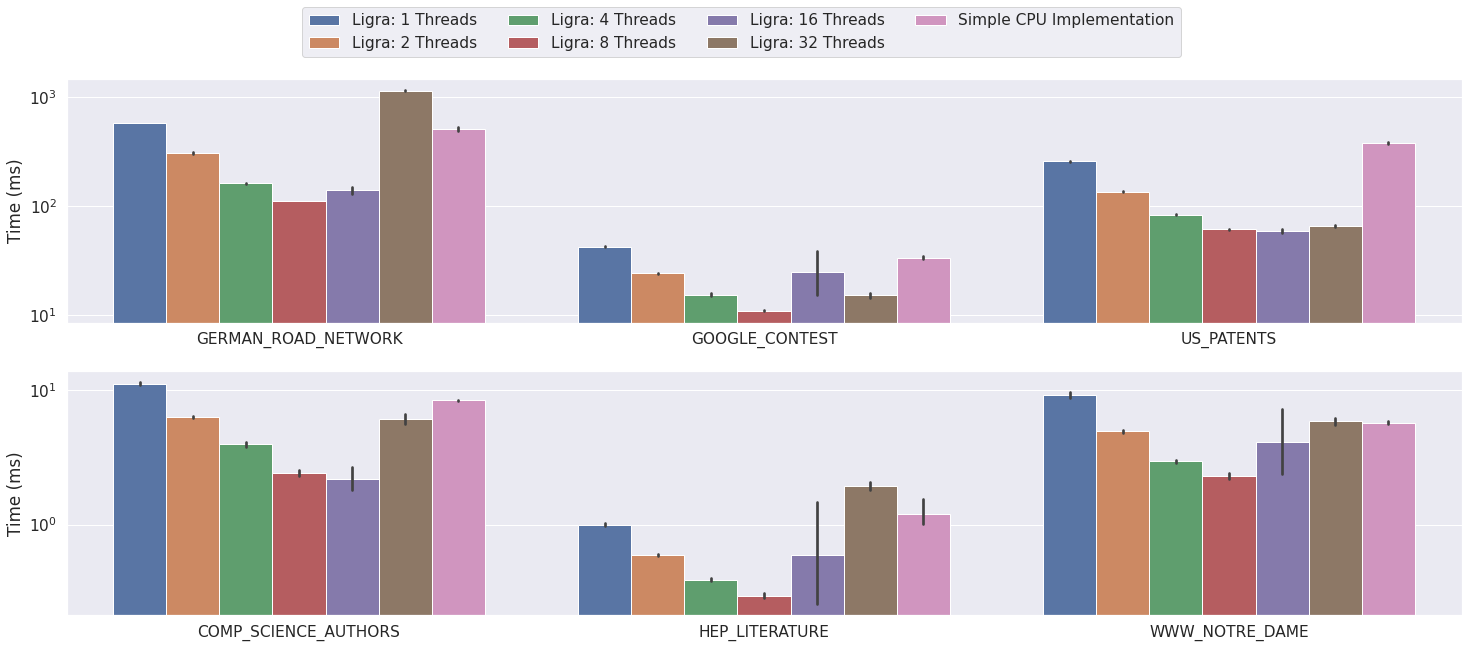

In [18]:
y='time'
def plot_ligrabfs(ligra_bfs_times, y, ax=None, show_copy=False):
  def adjust_name(x):
    (threadcount, algo) = x
    if algo == 'ligra':
        return 'Ligra: ' + str(threadcount) + ' Threads'
    else:
      return 'Simple CPU Implementation'
  plot = sns.barplot(data=ligra_bfs_times, x='Graph Name', y=y, hue=ligra_bfs_times[['threadcount', 'algo']].apply(adjust_name, axis=1), ax=ax)
  plot.get_legend().remove()
  plot.set(yscale='log')
  plot.set(xlabel='')
  plot.set(ylabel='Time (ms)')
  
plot_full_bfs(ligra_bfs_times, y, show_copy=True, plot_fun=plot_ligrabfs, ncol=4, legend_adjust=0.98)
plt.savefig("plots/cpu_bfs_realworld.svg",bbox_inches='tight')

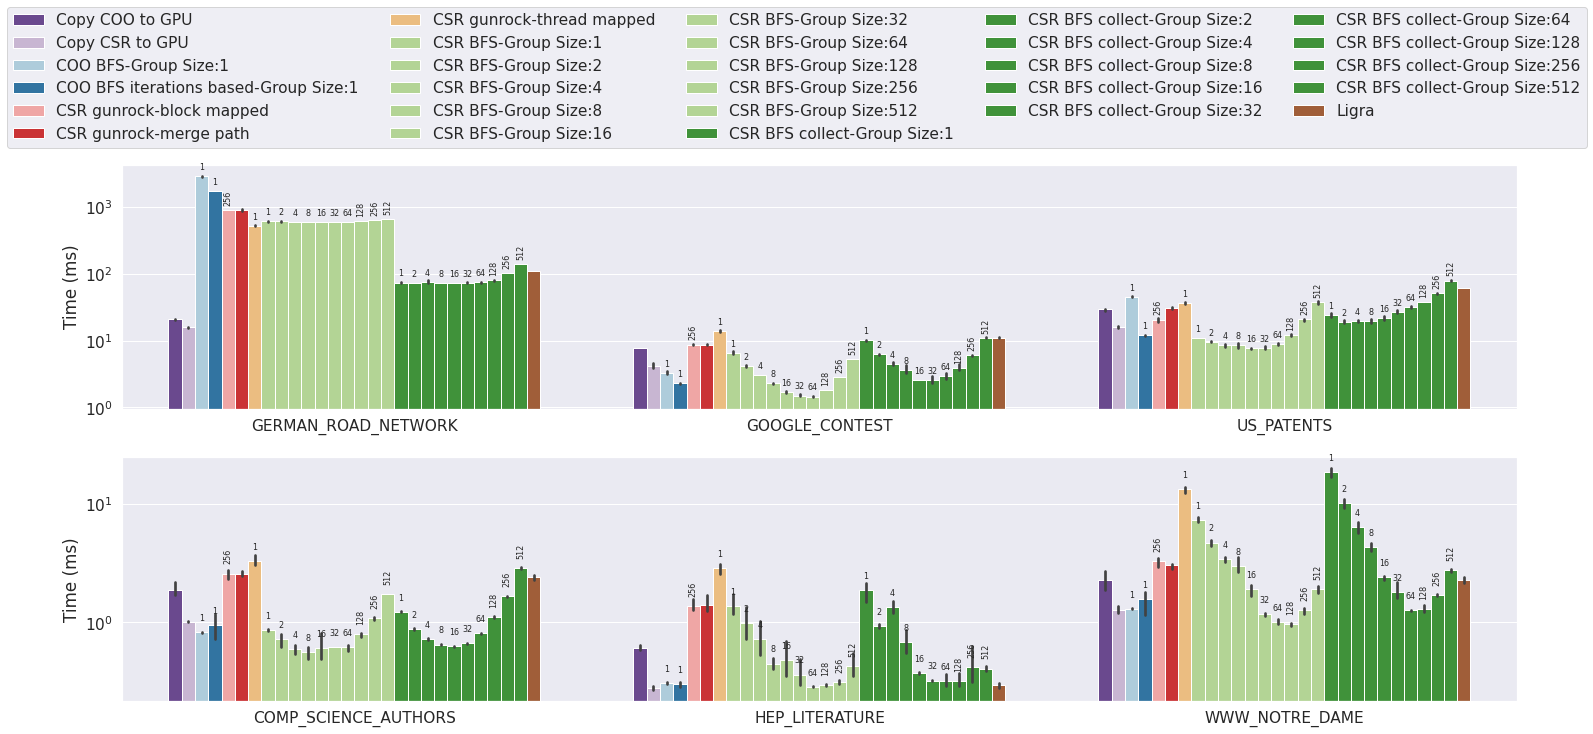

In [19]:
plot_full_bfs(bfs_times, y='time', show_copy=True, legend_adjust=1.1)
plt.savefig("plots/bfs_realworld.svg",bbox_inches='tight')

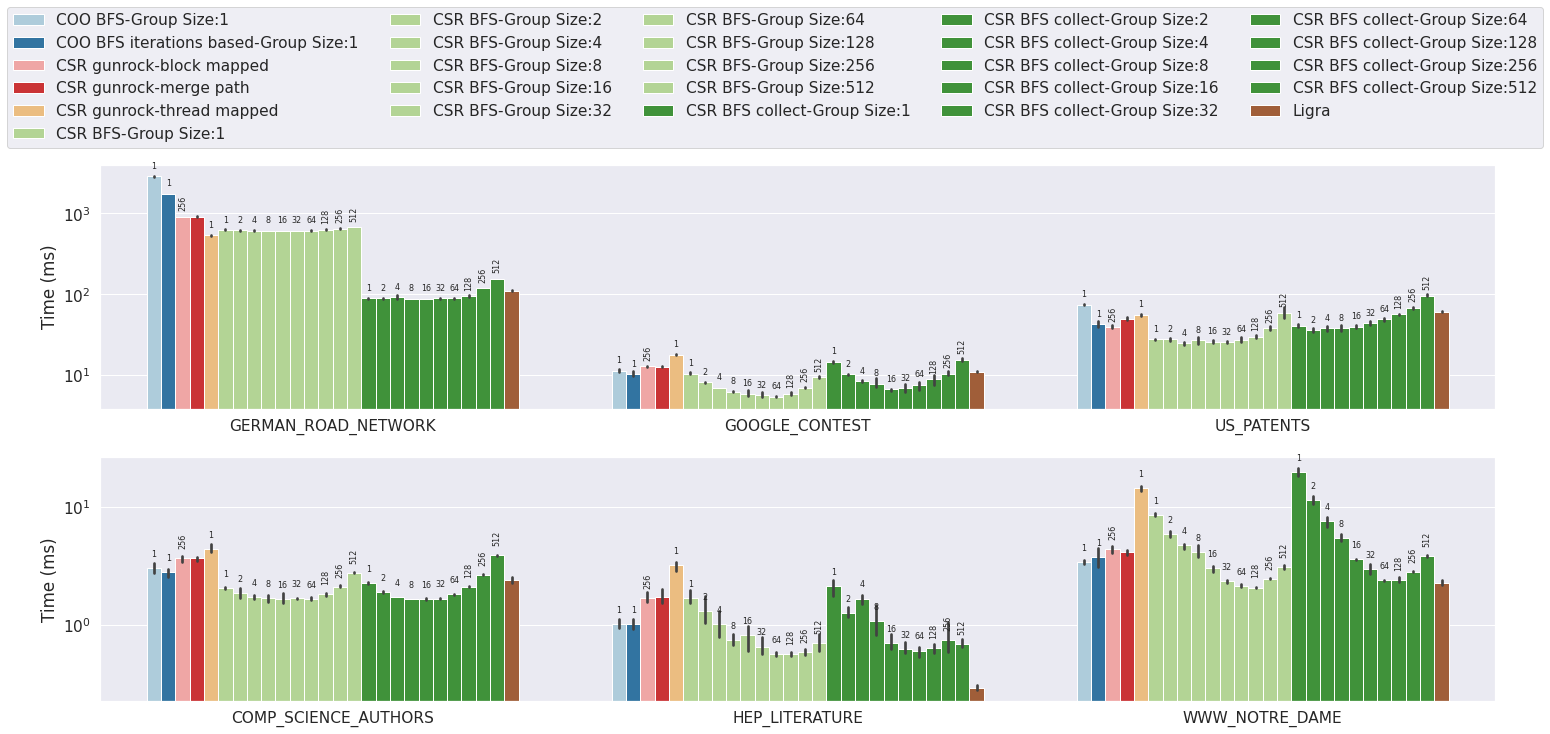

In [20]:
plot_full_bfs(bfs_times, y='total_time', legend_adjust=1.1)
plt.savefig("plots/bfs_realworld2.svg",bbox_inches='tight')